<a href="https://colab.research.google.com/github/intencjusz/machine-learning/blob/main/supervised/02_regression%20/04_backward_elimination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

sns.set()

np.random.seed(42)
np.set_printoptions(precision = 4, suppress = True)


In [3]:
df_raw = pd.read_csv('https://storage.googleapis.com/esmartdata-courses-files/ml-course/insurance.csv')
df_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Utworzenie kopii danych

In [4]:
df= df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Eksplorcja i wstępne przygotowanie danych

In [5]:
df[df.duplicated]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [6]:
df[df['charges']  == 1639.5631]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [8]:
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [10]:
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
cat_cols

['sex', 'smoker', 'region']

In [11]:
for col in cat_cols:
  df[col]= df[col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [15]:
df.describe(include =['category']).T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


In [16]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [17]:
df.sex.value_counts()

,count
sex,
male,676
female,662


<Axes: ylabel='count'>

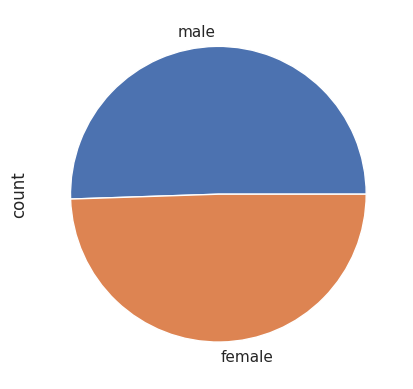

In [19]:
df.sex.value_counts().plot(kind='pie')

In [20]:
df.smoker.value_counts()

,count
smoker,
no,1064
yes,274


In [21]:
df.region.value_counts()

,count
region,
southeast,364
northwest,325
southwest,325
northeast,324


<Axes: ylabel='Frequency'>

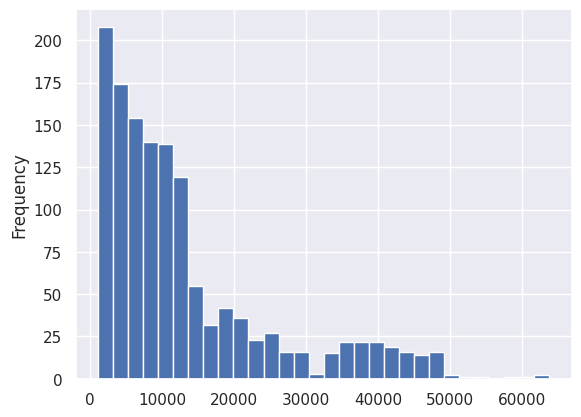

In [22]:
df.charges.plot(kind='hist', bins = 30)

In [23]:
import plotly.express as px
px.histogram(df, x='smoker', facet_col='sex', color='sex', width = 700, height=400)

In [24]:
px.histogram(df, x = 'charges', width=700, height=400, nbins = 50, facet_col = 'smoker', facet_row='sex')

In [25]:
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,True,False,True,False,False
1334,18,31.920,0,2205.98080,False,False,False,False,False
1335,18,36.850,0,1629.83350,False,False,False,True,False
1336,21,25.800,0,2007.94500,False,False,False,False,True


In [27]:
corr = df_dummies.corr()
corr

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109272,0.042469,0.299008,-0.020856,-0.025019,-0.000407,-0.011642,0.010016
bmi,0.109272,1.000000,0.012759,0.198341,0.046371,0.003750,-0.135996,0.270025,-0.006205
children,0.042469,0.012759,1.000000,0.067998,0.017163,0.007673,0.024806,-0.023066,0.021914
charges,0.299008,0.198341,0.067998,1.000000,0.057292,0.787251,-0.039905,0.073982,-0.043210
sex_male,-0.020856,0.046371,0.017163,0.057292,1.000000,0.076185,-0.011156,0.017117,-0.004184
smoker_yes,-0.025019,0.003750,0.007673,0.787251,0.076185,1.000000,-0.036945,0.068498,-0.036945
region_northwest,-0.000407,-0.135996,0.024806,-0.039905,-0.011156,-0.036945,1.000000,-0.346265,-0.320829
region_southeast,-0.011642,0.270025,-0.023066,0.073982,0.017117,0.068498,-0.346265,1.000000,-0.346265
region_southwest,0.010016,-0.006205,0.021914,-0.043210,-0.004184,-0.036945,-0.320829,-0.346265,1.000000


<Axes: >

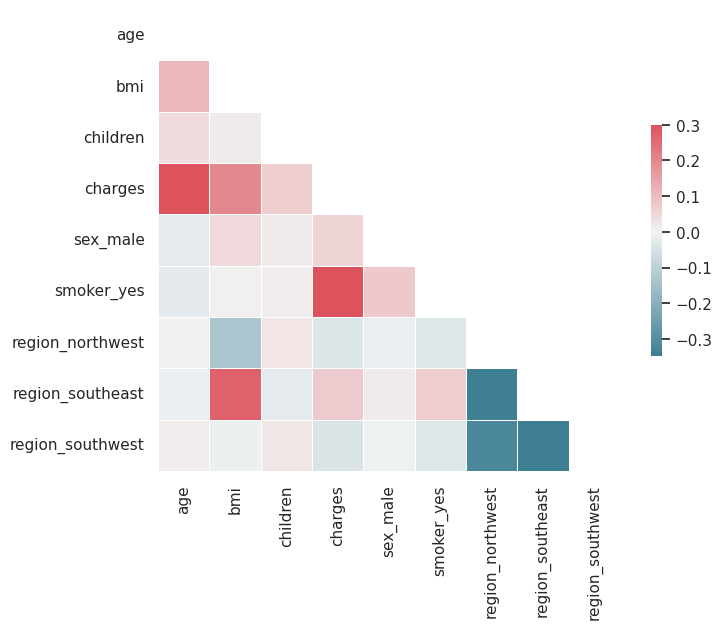

In [30]:
sns.set(style="white")
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [31]:
df_dummies.corr()['charges'].sort_values(ascending=False)

,charges
charges,1.000000
smoker_yes,0.787251
age,0.299008
bmi,0.198341
region_southeast,0.073982
children,0.067998
sex_male,0.057292
region_northwest,-0.039905
region_southwest,-0.043210


<Axes: >

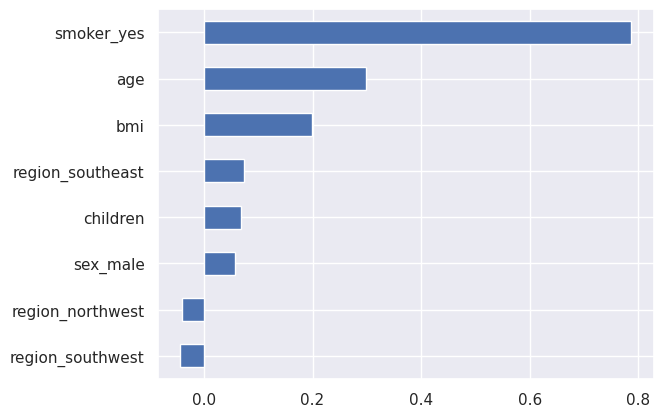

In [32]:
sns.set()
df_dummies.corr()['charges'].sort_values()[:-1].plot(kind='barh')

In [37]:
data = df_dummies.copy()
target = data.pop('charges')
data.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,False,True,False,False,True
1,18,33.770,1,True,False,False,True,False
2,28,33.000,3,True,False,False,True,False
3,33,22.705,0,True,False,True,False,False
4,32,28.880,0,True,False,True,False,False


In [39]:
target.head()

,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520


Podział danych na zbiór treningowy i testowy

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1070, 8)
X_test shape: (268, 8)
y_train shape: (1070,)
y_test shape: (268,)


Regresja liniowa

In [46]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [48]:
print(f'R2 score: {regressor.score(X_test, y_test):.4f}')

R2 score: 0.7596


In [49]:
y_pred = regressor.predict(X_test)
y_pred[:10]

array([25750.6316,  5301.2806, 11276.7546, 10103.0444, 10093.7818,
       16358.1919,  9287.9144,  5484.6697, 15528.6136, 39166.0707])

In [50]:
y_true=y_test.copy()
predictions = pd.DataFrame(data = {'y_true': y_true, 'y_pred': y_pred})
predictions['error'] = predictions['y_true']-predictions['y_pred']
predictions.head()

,y_true,y_pred,error
1252,16232.84700,25750.631612,-9517.784612
570,3761.29200,5301.280574,-1539.988574
1330,12629.16560,11276.754641,1352.410959
59,5989.52365,10103.044387,-4113.520737
796,4266.16580,10093.781789,-5827.615989


<Axes: ylabel='Frequency'>

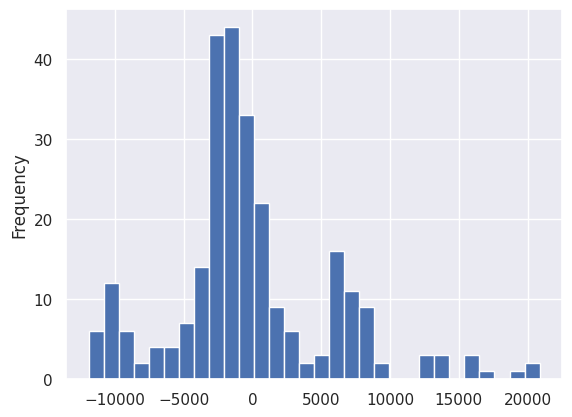

In [51]:
predictions.error.plot(kind = 'hist', bins = 30)

In [53]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE wynosi: {mae:.2f}")

MAE wynosi: 4208.05


In [54]:
regressor.intercept_

-11449.371079437036

In [55]:
regressor.coef_

array([  254.1166,   325.3894,   471.5248,  -335.0209, 24165.355 ,
        -179.0088, -1077.09  ,  -595.792 ])

Dobór cech modelu - eliminacja wsteczna

In [56]:
import statsmodels.api as sm

X_train_ols = X_train.copy()
X_train_ols = X_train_ols.values
X_train_ols = sm.add_constant(X_train_ols)
X_train_ols

array([[1.0, 36, 28.025, ..., False, False, False],
       [1.0, 56, 35.8, ..., False, False, True],
       [1.0, 40, 19.8, ..., False, True, False],
       ...,
       [1.0, 29, 38.94, ..., False, True, False],
       [1.0, 56, 34.43, ..., False, True, False],
       [1.0, 53, 38.06, ..., False, True, False]], dtype=object)

In [61]:
X_train = X_train.apply(pd.to_numeric, errors='coerce').dropna()
y_train = pd.to_numeric(y_train, errors='coerce')

ols = sm.OLS(endog=y_train, exog=X_train_ols).fit()
predictors = ['const'] + list(X_train.columns)
print(ols.summary(xname=predictors))

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

Eliminacja wsteczna - automatyzacja

In [63]:
import numpy as np
import statsmodels.api as sm

# Konwersja i czyszczenie danych
X_train = X_train.apply(pd.to_numeric, errors='coerce').dropna()
y_train = pd.to_numeric(y_train, errors='coerce')

# Zamiana na NumPy i dodanie stałej
X_train_numpy = X_train.values.astype(float)
X_train_numpy = sm.add_constant(X_train_numpy)

# Inicjalizacja zmiennych
num_vars = X_train_numpy.shape[1]
predictors = ['const'] + list(X_train.columns)
sl = 0.05

# Pętla eliminująca predyktory
for i in range(0, num_vars):
    ols = sm.OLS(endog=y_train, exog=X_train_numpy).fit()
    max_pval = max(ols.pvalues.astype('float'))
    if max_pval > sl:
        for j in range(0, X_train_numpy.shape[1]):
            if ols.pvalues[j].astype('float') == max_pval:
                X_train_numpy = np.delete(X_train_numpy, j, axis=1)
                predictors.pop(j)
                break

# Wyświetlenie podsumowania
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     786.2
Date:                Sat, 16 Nov 2024   Prob (F-statistic):          5.42e-316
Time:                        14:18:29   Log-Likelihood:                -10846.
No. Observations:                1070   AIC:                         2.170e+04
Df Residuals:                    1065   BIC:                         2.173e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.15e+04   1058.290    -10.863      0.0

<ipython-input-63-bd16598fe8f3>:23: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-63-bd16598fe8f3>:23: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-63-bd16598fe8f3>:23: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-63-bd16598fe8f3>:23: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consisten

In [64]:

ols.save('model.pickle')